# Testing the created framework

In [1]:
from utils import *
from pytorchNet import MLP, train_pytorch_model, generate_images
import framework as frw
import torch
import seaborn as sns
import glob
import cv2
%load_ext autoreload
%autoreload 2

## Load dataset

In [2]:
train_set, train_target = generate_disc_set(2500)
test_set, test_target = generate_disc_set(2500)

## Create a model & test forward

In [3]:
model = create_model()
output = model.forward(train_set,no_grad=True)

## Test the backward and no_grad

### No_grad

In [4]:
criterion = frw.MSELoss()
output = model.forward(train_set,no_grad=True)
loss = criterion.forward(output,train_target)
grdwrtoutput = criterion.backward()

In [5]:
model.backward(grdwrtoutput)

'Tanh : Forward step has not been performed'

### backward with grad

In [6]:
output = model.forward(train_set,no_grad=False)
loss = criterion.forward(output,train_target)
grdwrtoutput = criterion.backward()

In [7]:
model.backward(grdwrtoutput)

### Check the shapes of the gradients 

In [8]:
for module in model.sequence:
    print(module)
    if len(module.params[module]["par"]) > 0:
        print(module.params[module]["par"][0].shape)
        print(module.params[module]["par"][1].shape)

torch.Size([16, 2])
torch.Size([16, 1])
torch.Size([16, 16])
torch.Size([16, 1])
torch.Size([16, 16])
torch.Size([16, 1])
torch.Size([16, 16])
torch.Size([16, 1])
torch.Size([1, 16])
torch.Size([1, 1])


In [9]:
print(model.params)

{<framework.Linear object at 0x000001BF7E727588>: {'par': [tensor([[-0.2393, -0.1616],
        [ 0.4087, -0.3947],
        [-0.5101, -0.2485],
        [ 0.3024, -0.4141],
        [ 0.2186,  0.1738],
        [ 0.4935,  0.2025],
        [-0.3104, -0.2132],
        [ 0.4552,  0.1770],
        [ 0.5389,  0.5142],
        [ 0.1361, -0.2734],
        [-0.0029,  0.5099],
        [-0.4551, -0.5198],
        [ 0.5536,  0.2216],
        [ 0.4575,  0.0983],
        [ 0.1294, -0.1871],
        [ 0.0710,  0.2537]]), tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]])], 'grdpar': [tensor([[ 0.0000,  0.0000],
        [ 0.0021, -0.0047],
        [ 0.0000,  0.0000],
        [-0.0022,  0.0026],
        [-0.0027, -0.0034],
        [ 0.0173,  0.0058],
        [ 0.0000,  0.0000],
        [ 0.0346, -0.0027],
        [-0.0069,  0.0044],
 

In [10]:
laye = frw.Linear(3,4)
laye.params

{<framework.Linear at 0x1bf058b2a90>: {'par': [tensor([[ 0.4942, -0.8686, -0.0632],
           [ 0.2377, -0.0800,  0.4163],
           [ 0.2042,  0.5073,  0.9120],
           [ 0.3163, -0.5814,  0.4696]]),
   tensor([[0.],
           [0.],
           [0.],
           [0.]])],
  'grdpar': [tensor([[0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.],
           [0., 0., 0.]]),
   tensor([[0.],
           [0.],
           [0.],
           [0.]])]}}

# Try to train a model 

In [11]:
model = create_model()
params_frw = model.params
model_torch = MLP()
count = 0
with torch.no_grad():
    for par in model_torch.parameters():
        if len(params_frw[model.sequence[count]]["par"]) == 0:
            count += 1
        key = model.sequence[count]
        if len(par.shape) > 1:
            par -= par - params_frw[key]["par"][0]
        else:
            par -= par + torch.zeros_like(par)
            count += 1

In [12]:
train_model(model,train_set,train_target,epochs=50)
train_pytorch_model(model_torch,train_set,train_target,epochs=50)

In [13]:
accuracy_test = compute_nb_errors(model,test_set,test_target)
accuracy_train = compute_nb_errors(model,train_set,train_target)

In [14]:
print("accuracy on train set = ",round(accuracy_train,1))
print("accuracy on test set = ",round(accuracy_test,1))

accuracy on train set =  94.8
accuracy on test set =  95.0


## Comparison with Pytorch

In [ ]:
torch.manual_seed(100)
model_torch = MLP()
train_pytorch_model(model_torch,train_set,train_target,epochs=50)

In [ ]:
accuracy_test = compute_nb_errors(model_torch,test_set,test_target,pytorch=True)
accuracy_train = compute_nb_errors(model_torch,train_set,train_target,pytorch=True)

In [ ]:
print("accuracy on train set = ",round(accuracy_train,1))
print("accuracy on test set = ",round(accuracy_test,1))

# Visualization

In [15]:
X = torch.linspace(0,1,1000)
Y = torch.linspace(0,1,1000)
grid_x, grid_y = torch.meshgrid(X,Y)
grid_x_vector = grid_x.reshape(-1,1)
grid_y_vector = grid_y.reshape(-1,1)
inputs = torch.cat((grid_x_vector,grid_y_vector),dim=1)
predicted = model.forward(inputs,no_grad=True)
predicted = predicted.reshape(grid_x.shape[0],-1)
with torch.no_grad():
    predicted_torch = model_torch(inputs)
    predicted_torch = predicted_torch.reshape(grid_x.shape[0],-1)

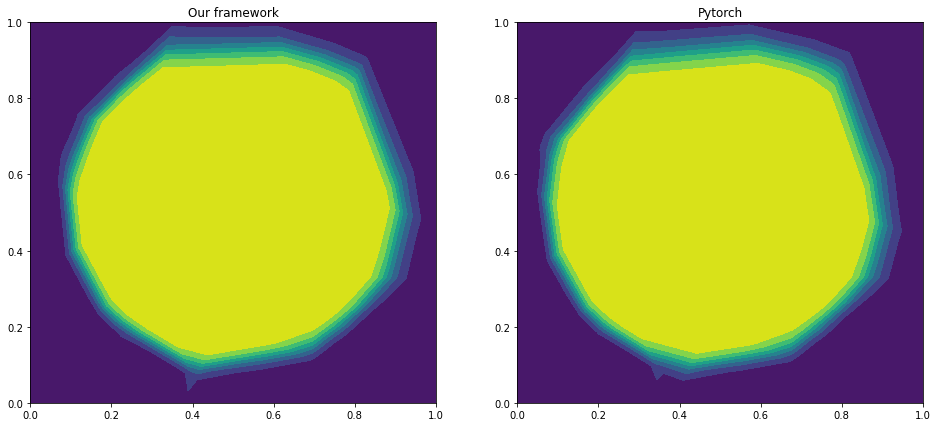

In [16]:
fig = plt.figure(figsize=[16,7])
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
cs1 = ax1.contourf(grid_x,grid_y,predicted)
cs2 = ax2.contourf(grid_x,grid_y,predicted_torch)
ax1.set_title("Our framework")
ax2.set_title("Pytorch")
plt.show()

Run                 Accuracy Train           Accuracy Test            
---                 --------------           -------------            
0                   99.0999984741211         97.69999694824219        
1                   99.29999542236328        98.29999542236328        
2                   99.4000015258789         98.0999984741211         
3                   99.4000015258789         97.79999542236328        
4                   98.5999984741211         98.0999984741211         
5                   97.79999542236328        95.5                     
6                   99.19999694824219        98.29999542236328        
7                   98.4000015258789         96.80000305175781        
8                   98.9000015258789         97.5999984741211         
9                   99.19999694824219        98.9000015258789         


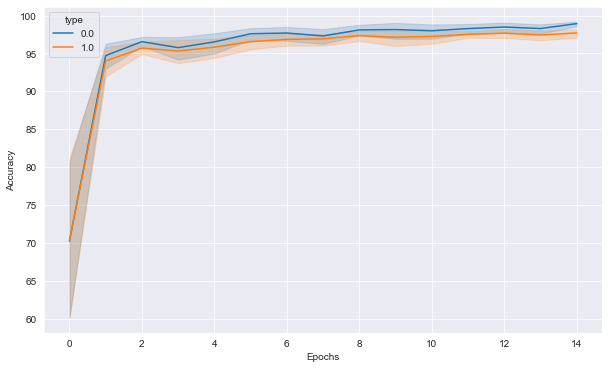

In [25]:
data = assess_model(create_model,15,1)

In [ ]:
columns = ["Run","Accuracy train","Accuracy test","Epochs"]
data_pd = pd.DataFrame(data,columns=columns)
fig = plt.figure(figsize=[10,6])
ax = fig.add_subplot(1,1,1)
sns.set_style("darkgrid")
sns.lineplot(data=data_pd,x="Epochs",y="Accuracy train",ax=ax)
sns.lineplot(data=data_pd,x="Epochs",y="Accuracy test",ax=ax)
plt.show()

# GIF

In [ ]:
model = create_model()
model_torch = MLP()
steps=3
epochs=90
params_frw = model.params
count = 0
with torch.no_grad():
    for par in model_torch.parameters():
        if len(params_frw[model.sequence[count]]["par"]) == 0:
            count += 1
        key = model.sequence[count]
        if len(par.shape) > 1:
            par -= par - params_frw[key]["par"][0]
        else:
            par -= par + torch.zeros_like(par)
            count += 1
generate_images(train_set,train_target,model,model_torch,steps,epochs,folder="figures")

In [ ]:
path_img = ["figures/epochs" + str(nb_epochs) + ".jpg" for nb_epochs in range(steps,epochs+1,steps)]
img_arr = []
for filename in path_img:
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_arr.append(img)
 

out = cv2.VideoWriter('mygif.avi',cv2.VideoWriter_fourcc(*'DIVX'), 3, size)
 
for i in range(len(img_arr)):
    out.write(img_arr[i])
out.release()